### Prospeção de Dados 2023/2024 - Course Project
#### Professor: André Falcão
#### Alunos: 

Catherine Prokhorov (62608) - XX Hours <br>
Guilherme Cepeda (62931) - XX Hours <br>
Jorge Aleluia (54549) - XX Hours <br>
Rómulo Nogueira (56935) - XX Hours <br>

#### Library

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
## import the data
activity_train = pd.read_csv("activity_train.csv", names=['uniprot_id', 'mol_id', 'activity'])
activity_test_blanked = pd.read_csv("activity_test_blanked.csv", names=['uniprot_id', 'mol_id', 'activity'])

## loading the fingerprints
with open("mol_bits.pkl", "rb") as f:
    mol_bits = pickle.load(f)

  uniprot_id          mol_id  activity
0     O14842   CHEMBL2022243         4
1     O14842   CHEMBL2022244         6
2     O14842   CHEMBL2022245         2
3     O14842   CHEMBL2022246         1
4     O14842   CHEMBL2022247         4
            activity
count  135711.000000
mean        4.708793
std         2.869907
min         1.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Missing Values: 
uniprot_id    0
mol_id        0
activity      0
dtype: int64


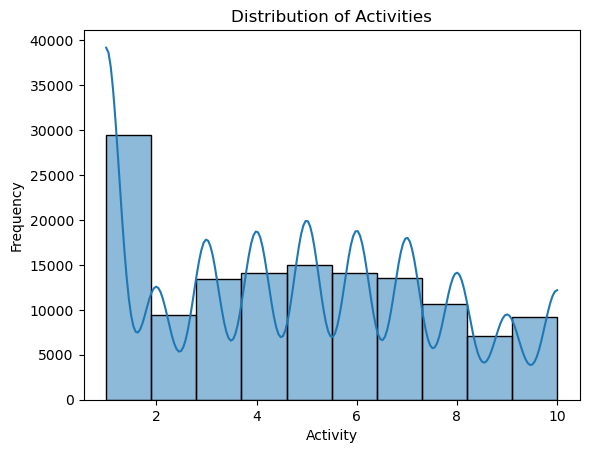

In [3]:
# Exploratory Data Analysis
print(activity_train.head())
print(activity_train.describe())

print(f'Missing Values: \n{activity_train.isnull().sum()}')

sns.histplot(activity_train['activity'], bins=10, kde=True)
plt.title('Distribution of Activities')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.show()

In [4]:
# dataframe with bits as columns
def create_features(mol_bits, ids):
    features = []
    for chembl_id in ids:
        bits = mol_bits.get(chembl_id, [])
        feature = [0] * 2048
        for bit in bits:
            feature[bit] = 1
        features.append(feature)
    return np.array(features)

MSE: 8.312784951004513
R²: -3.991565734628999e-05


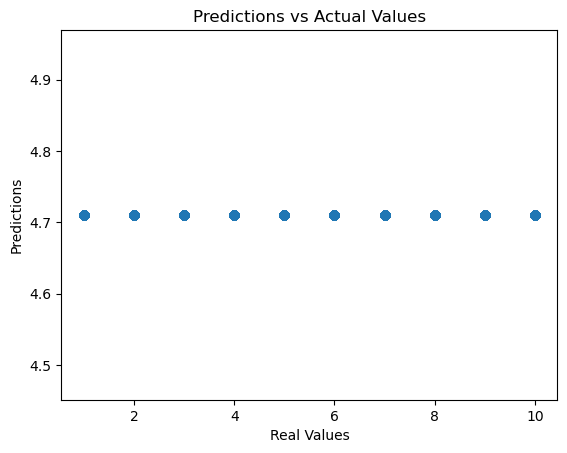

In [5]:
# features and target for training
X_train = create_features(mol_bits, activity_train['mol_id'])
y_train = activity_train['activity']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# training the model using the RFR
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'MSE: {mse}')
print(f'R²: {r2}')

# Visualizar previsões vs valores reais
plt.scatter(y_val, y_pred)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values')
plt.show()

# # Predictions on test set
# X_test = create_features(mol_bits, activity_test_blanked['mol_id'])
# predictions = model.predict(X_test)

# activity_test_blanked['activity'] = predictions
# activity_test_blanked.to_csv('preds_xx.txt', index=False, header=True)

Content-Based - MSE: 14.522581786030061
Content-Based - R²: -0.7470873540008323


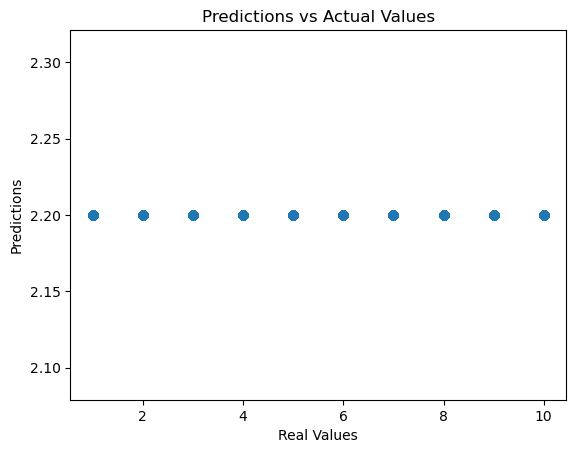

In [6]:
# Método 2: Content-Based (Nearest Neighbors)
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train)
distances, indices = nn.kneighbors(X_val)

y_pred_cb = np.array([y_train[indices[i]].mean() for i in range(len(y_val))])
mse_cb = mean_squared_error(y_val, y_pred_cb)
r2_cb = r2_score(y_val, y_pred_cb)
print(f'Content-Based - MSE: {mse_cb}')
print(f'Content-Based - R²: {r2_cb}')

# Visualizar previsões vs valores reais
plt.scatter(y_val, y_pred_cb)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values')
plt.show()

C:\Users\caapv\AppData\Local\Temp\ipykernel_17300\1088713052.py:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val_interactions = val_interactions.loc[common_proteins, common_molecules]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Collaborative Filtering - MSE: 29.54192704722517
Collaborative Filtering - R²: -2.5867927264439214


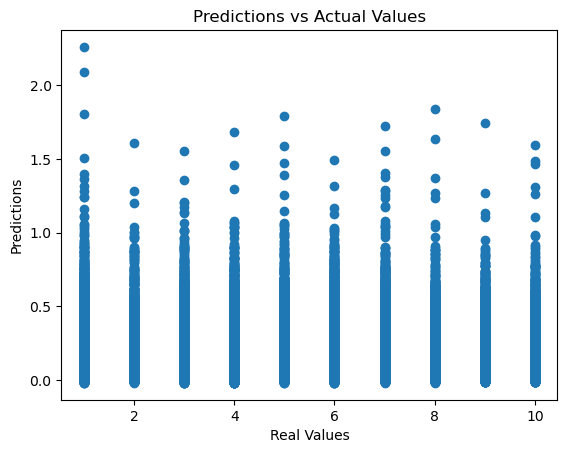

In [7]:
# Método 3: Collaborative Filtering (Latent Factors)
interaction_matrix = activity_train.pivot(index='uniprot_id', columns='mol_id', values='activity').fillna(0)
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(interaction_matrix)

# verificar se os dados de validação estao no mesmo formato que os dados de treino
val_interactions = activity_train.pivot(index='uniprot_id', columns='mol_id', values='activity').fillna(0)
common_proteins = set(interaction_matrix.index) & set(val_interactions.index)
common_molecules = set(interaction_matrix.columns) & set(val_interactions.columns)

val_interactions = val_interactions.loc[common_proteins, common_molecules]
val_latent = svd.transform(val_interactions)

y_pred_cf = np.dot(val_latent, svd.components_)
y_pred_cf = y_pred_cf[val_interactions.values.nonzero()]
y_val_cf = val_interactions.values[val_interactions.values.nonzero()]

mse_cf = mean_squared_error(y_val_cf, y_pred_cf)
r2_cf = r2_score(y_val_cf, y_pred_cf)
print(f'Collaborative Filtering - MSE: {mse_cf}')
print(f'Collaborative Filtering - R²: {r2_cf}')

plt.scatter(y_val_cf, y_pred_cf)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values')
plt.show()

In [8]:
# Predictions on test set (with the final method)
X_test = create_features(mol_bits, activity_test_blanked['mol_id'])
predictions = model.predict(X_test)

activity_test_blanked['activity'] = predictions
activity_test_blanked.to_csv('preds_01.txt', index=False, header=True)